# Анализ тарифов сотового оператора

#### Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей
**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей
    
Примечание:

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Шаг 1. Откроем файлы с данными и изучим общую информацию

In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats

In [227]:
try:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
except FileNotFoundError:
    calls = pd.read_csv('../../datasets/project_4/calls.csv')
    internet = pd.read_csv('../../datasets/project_4/internet.csv')
    messages = pd.read_csv('../../datasets/project_4/messages.csv')
    tariffs = pd.read_csv('../../datasets/project_4/tariffs.csv')
    users = pd.read_csv('../../datasets/project_4/users.csv')

pd.set_option('display.max_columns', None)

Откроем файлы с данными и посмотрим информацию о них

In [228]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [229]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


**Таблица calls (информация о звонках):**
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

In [230]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [231]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


**Таблица internet (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

In [232]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [233]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


**Таблица messages (информация о сообщениях):**
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

In [234]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [235]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Таблица tariffs (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [236]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [237]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


**Таблица users (информация о пользователях):**
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

## Шаг 2. Подготовим данные

Так как в задании указано: **«Мегалайн» всегда округляет секунды до минут. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута**, округлим значения минут в таблице `calls` в большую сторону

In [238]:
calls['duration'] = calls['duration'].apply(math.ceil)

In [239]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


В таблице `internet` есть безымянный столбец `Unnamed: 0` не описанный в документации и значения которого совпадают со сначениями столбца `id`. Нужно его удалить

In [240]:
internet.pop('Unnamed: 0')

0              0
1              1
2              2
3              3
4              4
           ...  
149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, Length: 149396, dtype: int64

In [241]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Изменим тип данных даты на `datetime` во всех таблицах, где есть дата

In [242]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [243]:
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [244]:
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [245]:
users['reg_date'] = pd.to_datetime(users['reg_date'])

Добавим в таблицу `users` столбец с кодом тарифа, где 0 - smart, 1 - ultra

In [246]:
def tariff_categorizer(raw):
    if raw['tariff'] == 'smart':
        return 0
    else:
        return 1

In [247]:
users['tariff_cat'] = users.apply(tariff_categorizer, axis=1)

И удалим столбец `tariff`

In [248]:
users.pop('tariff')

0      ultra
1      smart
2      smart
3      ultra
4      ultra
       ...  
495    ultra
496    smart
497    smart
498    smart
499    smart
Name: tariff, Length: 500, dtype: object

Посчитаем для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам
* количество отправленных сообщений по месяцам
* объем израсходованного интернет-трафика по месяцам

И объединим все данные в одну таблицу

In [249]:
users_calls = calls.groupby(by=['user_id', calls['call_date'].dt.month])['duration'].agg(['count', 'sum']).reset_index()
users_calls.columns = ['user_id', 'month', 'calls_count', 'minutes_sum']

Так как в задании сказано: **«Мегалайн» всегда округляет мегабайты — до гигабайт. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону**, напишем функцию для приведения мегабайт к гигабайтам с округлением в большую сторону

In [250]:
def round_gb(raw):
    return math.ceil(raw['gb_sum'] / 1024)

In [251]:
users_internet = internet.groupby(by=['user_id', internet['session_date'].dt.month])['mb_used'].agg(['count', 'sum']).reset_index()
users_internet.columns = ['user_id', 'month', 'session_count', 'gb_sum']
users_internet['gb_sum'] = users_internet.apply(round_gb, axis=1)
total = users_calls.merge(users_internet, how='left', on=['user_id', 'month'])

In [252]:
users_messages = messages.groupby(by=['user_id', messages['message_date'].dt.month]).agg({'id':'count'}).reset_index()
users_messages.columns = ['user_id', 'month', 'msg_count']
total = total.merge(users_messages, how='left', on=['user_id', 'month'])

In [253]:
total.head(10)

,user_id,month,calls_count,minutes_sum,session_count,gb_sum,msg_count
0,1000,5,22,159,5.0,3.0,22.0
1,1000,6,43,172,49.0,23.0,60.0
2,1000,7,47,340,29.0,14.0,75.0
3,1000,8,52,408,29.0,14.0,81.0
4,1000,9,58,466,27.0,15.0,57.0
5,1000,10,57,350,27.0,15.0,73.0
6,1000,11,43,338,24.0,15.0,58.0
7,1000,12,46,333,21.0,10.0,70.0
8,1001,11,59,430,55.0,18.0,NaN
9,1001,12,63,414,41.0,14.0,NaN


In [254]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        3174 non-null   int64  
 1   month          3174 non-null   int64  
 2   calls_count    3174 non-null   int64  
 3   minutes_sum    3174 non-null   int64  
 4   session_count  3163 non-null   float64
 5   gb_sum         3163 non-null   float64
 6   msg_count      2678 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 198.4 KB


Видим, что в итоговой таблице появились пропуски. Скорее всего некоторые пользователи в определенные периоды не пользовались интернетом и не отправляли сообщения, следовательно эти пропуски можно заполнить нулями

In [255]:
total = total.fillna(0)

In [256]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        3174 non-null   int64  
 1   month          3174 non-null   int64  
 2   calls_count    3174 non-null   int64  
 3   minutes_sum    3174 non-null   int64  
 4   session_count  3174 non-null   float64
 5   gb_sum         3174 non-null   float64
 6   msg_count      3174 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 198.4 KB


Объединим таблицу `users` с таблицей `total`

In [257]:
total = total.merge(users, how='left', on='user_id')

Посчитаем помесячную выручку с каждого пользователя. Для этого: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

Напишем функции для подсчета разницы между полученными суммарными значениями звонков, сообщений и интернета и тарифными лимитами и добавим разницы в новые столбцы

In [258]:
def diff_minutes(raw):
    if raw['tariff_cat'] == 0:
        return raw['minutes_sum'] - tariffs['minutes_included'][0]
    else:
        return raw['minutes_sum'] - tariffs['minutes_included'][1]

In [259]:
total['diff_minutes'] = total.apply(diff_minutes, axis=1)

In [260]:
def diff_gb(raw):
    if raw['tariff_cat'] == 0:
        return raw['gb_sum'] - tariffs['mb_per_month_included'][0] / 1024
    else:
        return raw['gb_sum'] - tariffs['mb_per_month_included'][1] / 1024

In [261]:
total['diff_gb'] = total.apply(diff_gb, axis=1)

In [262]:
def diff_msg(raw):
    if raw['tariff_cat'] == 0:
        return int(raw['msg_count'] - tariffs['messages_included'][0])
    else:
        return int(raw['msg_count'] - tariffs['messages_included'][1])

In [263]:
total['diff_msg'] = total.apply(diff_msg, axis=1)

In [264]:
total.head(10)

,user_id,month,calls_count,minutes_sum,session_count,gb_sum,msg_count,age,churn_date,city,first_name,last_name,reg_date,tariff_cat,diff_minutes,diff_gb,diff_msg
0,1000,5,22,159,5.0,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2841,-27.0,-978
1,1000,6,43,172,49.0,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2828,-7.0,-940
2,1000,7,47,340,29.0,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2660,-16.0,-925
3,1000,8,52,408,29.0,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2592,-16.0,-919
4,1000,9,58,466,27.0,15.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2534,-15.0,-943
5,1000,10,57,350,27.0,15.0,73.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2650,-15.0,-927
6,1000,11,43,338,24.0,15.0,58.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2662,-15.0,-942
7,1000,12,46,333,21.0,10.0,70.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2667,-20.0,-930
8,1001,11,59,430,55.0,18.0,0.0,41,NaN,Москва,Иван,Ежов,2018-11-01,0,-70,3.0,-50
9,1001,12,63,414,41.0,14.0,0.0,41,NaN,Москва,Иван,Ежов,2018-11-01,0,-86,-1.0,-50


Посчитаем помесячную выручку с каждого пользователя функцией `total_cost` и добавим значения в новый столбец

In [265]:
def total_cost(raw):
    total_cost = 0
    if raw['diff_minutes'] > 0:
        total_cost += raw['diff_minutes'] * tariffs['rub_per_minute'][raw['tariff_cat']]
    if raw['diff_gb'] > 0:
        total_cost += raw['diff_gb'] * tariffs['rub_per_gb'][raw['tariff_cat']]
    if raw['diff_msg'] > 0:
        total_cost += raw['diff_msg'] * tariffs['rub_per_message'][raw['tariff_cat']]
    total_cost += tariffs['rub_monthly_fee'][raw['tariff_cat']]
    return total_cost

In [266]:
total['total_cost'] = total.apply(total_cost, axis=1)

In [267]:
total

,user_id,month,calls_count,minutes_sum,session_count,gb_sum,msg_count,age,churn_date,city,first_name,last_name,reg_date,tariff_cat,diff_minutes,diff_gb,diff_msg,total_cost
0,1000,5,22,159,5.0,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2841,-27.0,-978,1950.0
1,1000,6,43,172,49.0,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2828,-7.0,-940,1950.0
2,1000,7,47,340,29.0,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2660,-16.0,-925,1950.0
3,1000,8,52,408,29.0,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2592,-16.0,-919,1950.0
4,1000,9,58,466,27.0,15.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1,-2534,-15.0,-943,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,10,41,247,59.0,21.0,42.0,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,0,-253,6.0,-8,1750.0
3170,1499,9,9,70,5.0,2.0,11.0,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,0,-430,-13.0,-39,550.0
3171,1499,10,68,449,58.0,18.0,48.0,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,0,-51,3.0,-2,1150.0
3172,1499,11,74,612,49.0,18.0,59.0,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,0,112,3.0,9,1513.0


## Шаг 3. Проанализируем данные

**Задание**

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Найдем дисперсию, стандартное отклонение и среднее для минут в обоих тарифах

In [268]:
desc_table_minutes = total.pivot_table(index='tariff_cat', values='diff_minutes', aggfunc=[np.var, np.std, np.mean])
desc_table_minutes.columns = ['var_minutes', 'std_minutes', 'mean_minutes']
desc_table_minutes

,var_minutes,std_minutes,mean_minutes
tariff_cat,,,
0,35844.189551,189.325618,-80.937022
1,94203.418396,306.925754,-2454.548896


Найдем дисперсию, стандартное отклонение и среднее для интернет траффика в обоих тарифах

In [269]:
desc_table_gb = total.pivot_table(index='tariff_cat', values='diff_gb', aggfunc=[np.var, np.std, np.mean])
desc_table_gb.columns = ['var_gb', 'std_gb', 'mean_gb']
desc_table_gb

,var_gb,std_gb,mean_gb
tariff_cat,,,
0,33.092396,5.752599,1.329735
1,97.820643,9.890432,-10.512093


Найдем дисперсию, стандартное отклонение и среднее для количества сообщений в обоих тарифах

In [270]:
desc_table_msg = total.pivot_table(index='tariff_cat', values='diff_msg', aggfunc=[np.var, np.std, np.mean])
desc_table_msg.columns = ['var_msg', 'std_msg', 'mean_msg']
desc_table_msg

,var_msg,std_msg,mean_msg
tariff_cat,,,
0,798.595792,28.259437,-16.603689
1,2198.733603,46.890656,-950.966351


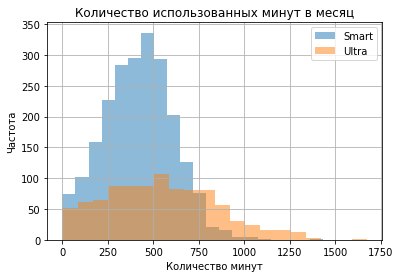

In [271]:
total.groupby('tariff_cat')['minutes_sum'].hist(bins=20, legend=True, alpha=.5);
plt.xlabel('Количество минут');
plt.ylabel('Частота');
plt.title('Количество использованных минут в месяц');
plt.legend(['Smart', 'Ultra']);

Данные практически симметричны. Почти у всех пользователей тарифа ultra остается большая часть неиспользованных минут тарифа, в то время как пользователи тарифа smart часто выходят за лимит минут своего тарифа

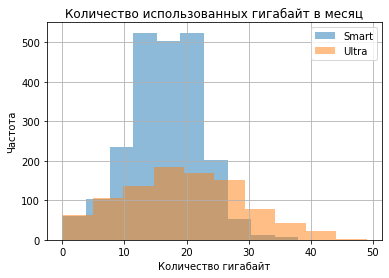

In [272]:
total.groupby('tariff_cat')['gb_sum'].hist(legend=True, alpha=.5);
plt.xlabel('Количество гигабайт');
plt.ylabel('Частота');
plt.title('Количество использованных гигабайт в месяц');
plt.legend(['Smart', 'Ultra']);

В данном случае данные так же симметричны. Большая часть пользователей тарифа smart выходят за лимит интернет траффика, в то время как у большей части пользователей тарифа ultra остаются неиспользованные гигабайты

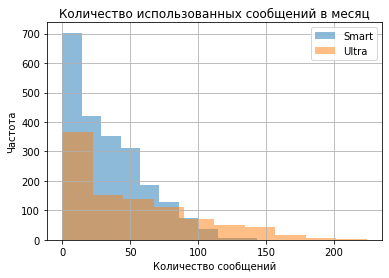

In [273]:
total.groupby('tariff_cat')['msg_count'].hist(bins=10, legend=True, alpha=.5);
plt.xlabel('Количество сообщений');
plt.ylabel('Частота');
plt.title('Количество использованных сообщений в месяц');
plt.legend(['Smart', 'Ultra']);

Здесь данные скошены вправо, пользователи тарифа ultra мало пользуются смс сообщениями, в среднем они отправляют 50 смс из 1000 доступных в тарифе. Пользователи тарифа smart, в среднем используют около 2/3 лимита сообщений

In [274]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        3174 non-null   int64         
 1   month          3174 non-null   int64         
 2   calls_count    3174 non-null   int64         
 3   minutes_sum    3174 non-null   int64         
 4   session_count  3174 non-null   float64       
 5   gb_sum         3174 non-null   float64       
 6   msg_count      3174 non-null   float64       
 7   age            3174 non-null   int64         
 8   churn_date     187 non-null    object        
 9   city           3174 non-null   object        
 10  first_name     3174 non-null   object        
 11  last_name      3174 non-null   object        
 12  reg_date       3174 non-null   datetime64[ns]
 13  tariff_cat     3174 non-null   int64         
 14  diff_minutes   3174 non-null   int64         
 15  diff_gb        3174 n

## Шаг 4. Проверим гипотезы

### Проверим первую гипотезу:

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**

Сформируем 2 выборки по тарифам:

In [275]:
smart_0 = total.query('tariff_cat == 0')
ultra_1 = total.query('tariff_cat == 1')
display(len(smart_0))
display(len(ultra_1))

2223

951

Исходя из задания, сформулируем нулевую гипотезу как равенство средних двух совокупностей:
    
**Средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт"**.

Критический уровень значимости установим в 5%.

Так как нам нужно сравнить средние двух независимых друг от друга выборок, используем метод `scipy.stats.ttest_ind()`, параметр `equal_var` установим в False, потому что выборки разного размера и их дисперсии не равны

In [276]:
alpha = 0.05

print(f'Средняя выручка пользователей тарифа Smart: {smart_0["total_cost"].mean()}')
print(f'Средняя выручка пользователей тарифа Ultra: {ultra_1["total_cost"].mean()}')
print()

result = scipy.stats.ttest_ind(smart_0['total_cost'], ultra_1['total_cost'], equal_var=False)

if result.pvalue < alpha:
    print(f'pvalue: {result.pvalue}')
    print('Отвергаем нулевую гипотезу')
else:
    print(f'pvalue:{result.pvalue}')
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка пользователей тарифа Smart: 1290.8911381016644
Средняя выручка пользователей тарифа Ultra: 2070.9779179810726

pvalue: 3.155173205867294e-245
Отвергаем нулевую гипотезу


Так как не задано конкретное значение, с которым нужно сравнить среднее одной из выборок, сформулируем первую гипотезу как неравенство средних двух совокупностей:

**Средняя выручка пользователей тарифа "Ультра" не равна средней выручке пользователей тарифа "Смарт"**.

Так как `pvalue` в данном случае получился очень маленьким, отвергаем нулевую гипотезу и принимаем первую.

### Проверим вторую гипотезу:

**Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

Сформируем 2 выборки: пользователи из Москвы и пользователи из остальных регионов

In [277]:
moscow_users = total.query('city == "Москва"')
other_users = total.query('city != "Москва"')
display(len(moscow_users))
display(len(other_users))

610

2564

Исходя из задания, сформулируем нулевую гипотезу как равенство средних двух совокупностей:
    
**Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов**.

Критический уровень значимости установим в 5%.

Так как нам нужно сравнить средние двух независимых друг от друга выборок, используем метод `scipy.stats.ttest_ind()`, параметр `equal_var` установим в False, потому что выборки разного размера и их дисперсии не равны

In [279]:
alpha = 0.05

print(f'Средняя выручка пользователей из Москвы: {moscow_users["total_cost"].mean()}')
print(f'Средняя выручка пользователей из других регионов: {other_users["total_cost"].mean()}')
print()

result = scipy.stats.ttest_ind(moscow_users['total_cost'], other_users['total_cost'], equal_var=False)

if result.pvalue < alpha:
    print(f'pvalue: {result.pvalue}')
    print("Отвергаем нулевую гипотезу")
else:
    print(f'pvalue: {result.pvalue}')
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка пользователей из Москвы: 1546.0524590163934
Средняя выручка пользователей из других регионов: 1519.5237909516381

pvalue: 0.44113705815091153
Не получилось отвергнуть нулевую гипотезу


Вероятность того, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов = 44%, следовательно мы не можем отвергнуть нулевую гипотезу

## Шаг 5. Напишем общий вывод

Мы провели исследование двух тарифных планов компании "Мегалайн". Исследование проводили на данных 500 пользователей за 2018 год. По предоставленным данным мы выяснили:
* большая часть пользователей тарифа "Ультра" не выходят за границы лимита по минутам, интернету и смс сообщениям
* пользователям тарифа "Смарт" часто не хватает минут и гигабайт, включенных в тарифный план
* пользователи тарифа "Смарт" иногда выходят за границы лимита по смс
* большая часть пользователей обоих тарифов практически не пользуется смс сообщениями

Так же в ходе исследования мы подтвердили одну гипотезу:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» действительно различаются

И опровергли вторую:
* средняя выручка пользователей из Москвы может не отличаться от выручки пользователей из других регионов